In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR)
overlap = int(SR/2)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')

In [5]:
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
classes = [None] * 50
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
h_classes = ['Human & Animal', 'Interacting Materials']

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [7]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=None,
                        blocksize=blocksize, 
                        overlap=overlap)

In [8]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.00000,2000.000000,2000.000000
mean,68.458234,41.711876,34.493312,29.603907,26.785781,26.477625,26.070203,26.029718,25.661683,25.149039,...,-0.025905,-0.023763,16.919189,29.299233,6.230198,9.204081e+11,4.409686,0.64000,24.500000,3.000000
std,26.404973,15.747895,16.224605,14.679204,14.933875,15.371118,15.328749,15.849333,15.871806,15.503510,...,0.062447,0.059585,52.761289,51.213696,16.108084,4.116190e+13,2.586990,0.48012,14.434479,1.414567
min,0.116061,0.138651,0.109184,0.185506,0.140898,0.199093,0.121979,0.136089,0.089897,0.075556,...,-0.401249,-0.356166,5.815685,11.600177,1.845860,8.430859e+00,0.372545,0.00000,0.000000,1.000000
25%,47.177445,29.895114,20.717070,16.013040,12.344110,11.573773,11.247905,10.476102,10.181782,9.668703,...,-0.063543,-0.059884,10.586711,20.305736,3.840916,1.702619e+01,2.522802,0.00000,12.000000,2.000000
50%,67.773387,41.225949,32.221844,27.930916,25.225453,24.370674,24.861090,24.837549,24.902718,24.756536,...,-0.019454,-0.018041,13.681475,24.745671,4.952721,2.174831e+01,4.123728,1.00000,24.500000,3.000000
75%,87.348496,52.391729,46.118609,41.677510,39.980926,40.545697,40.132695,40.162835,39.707970,39.142280,...,0.016168,0.014900,18.839947,33.486224,6.957205,2.905295e+01,5.780436,1.00000,37.000000,4.000000
max,152.990931,94.887900,92.678212,76.212504,75.001668,76.185901,84.761325,94.589380,106.607614,105.094272,...,0.162462,0.210591,2349.723324,2248.951556,709.768565,1.840816e+15,24.324563,1.00000,49.000000,5.000000


In [9]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [10]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# Training

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=30)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

params = {
          'n_estimators': range(5,25,1),
          'criterion': ('gini', 'entropy')
         }

rfc = RandomForestClassifier()

clf = GridSearchCV(rfc, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ('gini', 'entropy'), 'n_estimators': range(5, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_criterion',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.71875
Confusion matrix, without normalization
[[ 51  65]
 [ 25 179]]


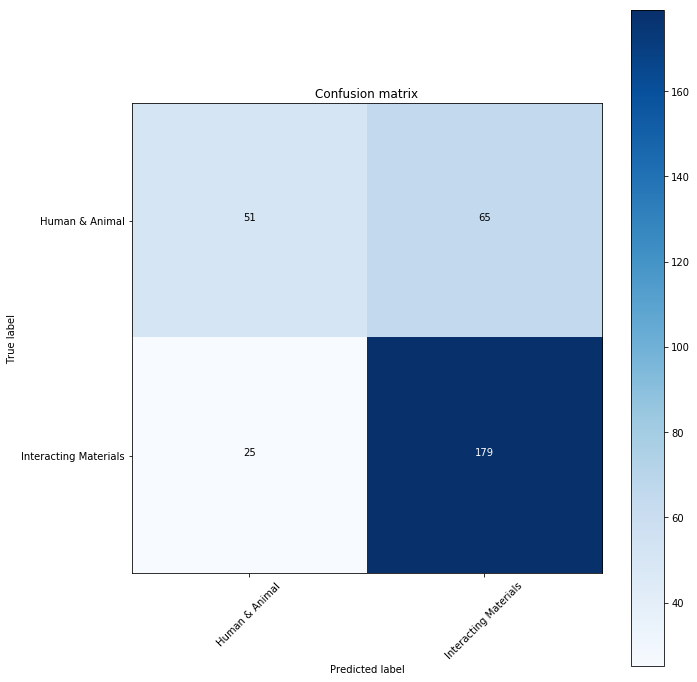

In [13]:
test_X = scaler.transform(test_X)
test_X = feat_red.transform(test_X)
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [14]:
all_df = df[df.fold == 1]

In [15]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,40.966990,26.258012,12.927575,13.748385,8.883775,5.561329,4.560276,7.306209,6.977689,7.903446,...,-0.401249,-0.356166,29.119574,25.008716,7.213768,31.710370,1.593856,0,0,1
1,58.869103,67.327057,44.134853,41.709899,46.205963,49.339181,56.324964,47.998394,54.018006,49.417586,...,-0.007047,-0.036911,16.238196,19.072190,4.976296,22.600347,7.369922,0,14,1
2,83.836738,54.627161,58.381023,49.516300,46.733215,45.306550,44.329287,40.751034,41.713781,44.541769,...,-0.001077,0.018140,15.451926,22.335173,4.331329,20.983961,4.313574,1,36,1
3,76.253088,58.427143,56.373360,46.296457,45.477336,47.587907,42.043968,44.252065,44.236598,48.171842,...,0.015215,-0.009535,14.044341,21.830457,4.555005,19.493051,5.333361,1,36,1
4,74.482026,57.172355,56.553450,46.430592,41.032768,42.444785,38.699774,38.342245,38.612357,39.772041,...,0.039366,-0.029240,12.366682,19.022622,4.046185,18.591737,4.606312,1,19,1


In [16]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']
X = scaler.transform(X)
X = feat_red.transform(X)

0.6725
Confusion matrix, without normalization
[[ 57  87]
 [ 44 212]]


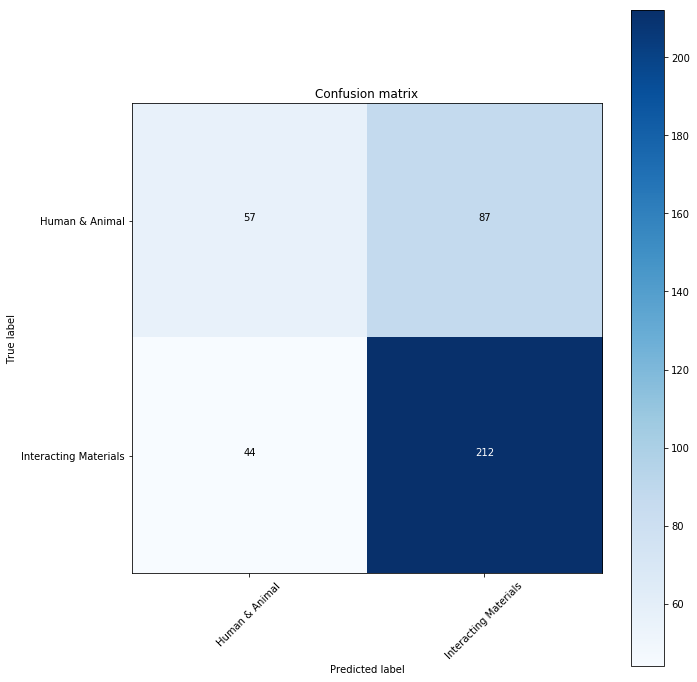

In [17]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [18]:
clf.best_estimator_ 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
import seaborn as sns
misclassified = {
    'h_target': [],
    'target': [],
    'prob_0': [],
    'prob_1': []
}
for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['target'].append(classes[int(row[1]['target'])])
        misclassified['h_target'].append(h_classes[p])
        misclassified['prob_0'].append(prob[0])
        misclassified['prob_1'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,h_target,prob_0,prob_1,target
0,Interacting Materials,0.347826,0.652174,dog
1,Interacting Materials,0.478261,0.521739,chirping_birds
2,Interacting Materials,0.434783,0.565217,crow
3,Human & Animal,0.521739,0.478261,door_wood_knock
4,Human & Animal,0.652174,0.347826,clapping


In [20]:
average_prob = misclassified.groupby('h_target').mean()
average_prob.head()

,prob_0,prob_1
h_target,,
Human & Animal,0.611660,0.388340
Interacting Materials,0.316342,0.683658


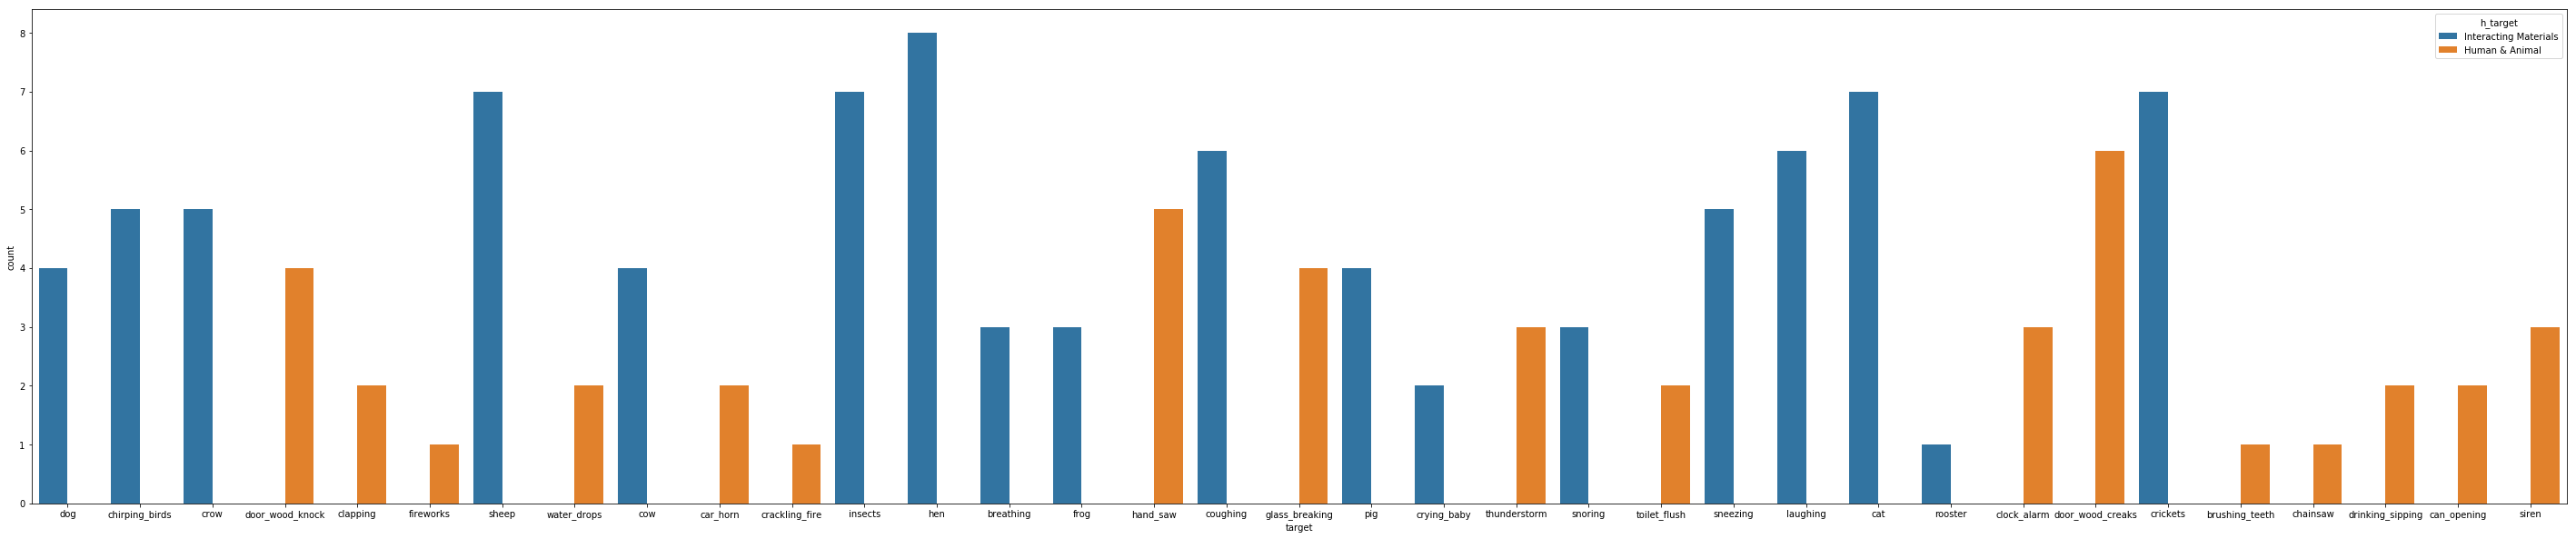

In [21]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='target', hue='h_target',data=misclassified)